## 1. Import Libraries

**feature_engine** package is commonly used for feature engineering tasks such as imputation, encoding, discretization, and more.

In [39]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## 2. Display Settings

In [40]:
pd.set_option("display.max_columns", None)  # if we have lots of columns pandas will not shows all using this we can see it 

In [41]:
sklearn.set_config(transform_output="pandas")# Sklearn transformer give numpy array as out if we want Dataframe as output we will use this

In [42]:
warnings.filterwarnings("ignore") #It will remove warning

## 3. Read the Data

In [43]:
path = r"C:\Users\samee\OneDrive\Desktop\AWS SAGEMAKER PROJECT\data\train.csv"

train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-05-15,Delhi,Cochin,17:05:00,22:15:00,310,1.0,No Info,6027
1,Multiple Carriers,2019-05-15,Delhi,Cochin,07:10:00,22:30:00,920,1.0,No Info,6513
2,Air India,2019-06-18,Delhi,Cochin,18:05:00,21:10:00,185,0.0,No Info,5201
3,Multiple Carriers,2019-05-27,Delhi,Cochin,12:50:00,21:00:00,490,1.0,No Info,7005
4,Multiple Carriers,2019-03-03,Delhi,Cochin,16:00:00,01:35:00,575,1.0,No Info,21226
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-03-12,Banglore,New Delhi,18:55:00,16:10:00,1275,1.0,In-flight meal not included,11087
636,Indigo,2019-05-12,Banglore,Delhi,07:10:00,10:05:00,175,0.0,No Info,4823
637,Multiple Carriers,2019-03-09,Delhi,Cochin,06:50:00,19:15:00,745,1.0,In-flight meal not included,14817
638,Air India,2019-03-01,Banglore,New Delhi,05:50:00,16:20:00,630,2.0,Change airports,15119


In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      639 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [45]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

## 4. Transformation Operations (Column wise)

### 4.1 airline

In [46]:
X_train.airline  # We are grouping rare categories as 'Other'

0                 Indigo
1      Multiple Carriers
2              Air India
3      Multiple Carriers
4      Multiple Carriers
             ...        
635          Jet Airways
636               Indigo
637    Multiple Carriers
638            Air India
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [47]:
air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),  # tol will group categories less than equal to 10 % and group 
    #done if we have two categories
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))  #we want to see output so we use dense NumPy array stores all elements, including zeros.
])  # if any new category came in testing data we will ignore it and mark as zero

air_transformer.fit_transform(X_train.loc[:, ["airline"]])#.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0
636,0.0,1.0,0.0,0.0,0.0
637,0.0,0.0,0.0,1.0,0.0
638,1.0,0.0,0.0,0.0,0.0


### 4.2 date_of_journey

In [48]:
X_train.date_of_journey

0      2019-05-15
1      2019-05-15
2      2019-06-18
3      2019-05-27
4      2019-03-03
          ...    
635    2019-03-12
636    2019-05-12
637    2019-03-09
638    2019-03-01
639    2019-05-01
Name: date_of_journey, Length: 640, dtype: object

In [49]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.647059,0.333333,0.635593
1,0.666667,0.647059,0.333333,0.635593
2,1.000000,0.941176,0.166667,0.923729
3,0.666667,0.764706,0.000000,0.737288
4,0.000000,0.000000,1.000000,0.016949
...,...,...,...,...
635,0.000000,0.117647,0.166667,0.093220
636,0.666667,0.588235,1.000000,0.610169
637,0.000000,0.058824,0.833333,0.067797
638,0.000000,0.000000,0.666667,0.000000


### 4.3 source & destination

In [50]:
X_train.source

0         Delhi
1         Delhi
2         Delhi
3         Delhi
4         Delhi
         ...   
635    Banglore
636    Banglore
637       Delhi
638    Banglore
639     Kolkata
Name: source, Length: 640, dtype: object

In [51]:
X_train.destination

0         Cochin
1         Cochin
2         Cochin
3         Cochin
4         Cochin
         ...    
635    New Delhi
636        Delhi
637       Cochin
638    New Delhi
639     Banglore
Name: destination, Length: 640, dtype: object

In [52]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Delhi,Cochin
3,Delhi,Cochin
4,Delhi,Cochin
...,...,...
635,Banglore,New Delhi
636,Banglore,Delhi
637,Delhi,Cochin
638,Banglore,New Delhi


In [53]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),   # using MeanEncoder each category will replace by target value mean
	("scaler", PowerTransformer())  # as value range is very large in input column we apply powerTransformer()
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,0.963946,0.960350
1,0.963946,0.960350
2,0.963946,0.960350
3,0.963946,0.960350
4,0.963946,0.960350
...,...,...
635,-1.230536,-0.854212
636,-1.230536,-1.830057
637,0.963946,0.960350
638,-1.230536,-0.854212


In [54]:
np.union1d(
	X_train.source.unique(),
	X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [55]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)  # isin give boolean value we convert it into integer( 0 and 1)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
635,0,1
636,0,1
637,1,0
638,0,1


**FeatureUnion** is a utility in Scikit-Learn used for combining multiple feature extraction or transformation pipelines.

In [56]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,0.963946,0.960350,1,0
1,0.963946,0.960350,1,0
2,0.963946,0.960350,1,0
3,0.963946,0.960350,1,0
4,0.963946,0.960350,1,0
...,...,...,...,...
635,-1.230536,-0.854212,0,1
636,-1.230536,-1.830057,0,1
637,0.963946,0.960350,1,0
638,-1.230536,-0.854212,0,1


### 4.4 dep_time & arrival_time

In [57]:
X_train.dep_time

0      17:05:00
1      07:10:00
2      18:05:00
3      12:50:00
4      16:00:00
         ...   
635    18:55:00
636    07:10:00
637    06:50:00
638    05:50:00
639    20:25:00
Name: dep_time, Length: 640, dtype: object

In [58]:
X_train.arrival_time

0      22:15:00
1      22:30:00
2      21:10:00
3      21:00:00
4      01:35:00
         ...   
635    16:10:00
636    10:05:00
637    19:15:00
638    16:20:00
639    23:35:00
Name: arrival_time, Length: 640, dtype: object

In [59]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,17:05:00,22:15:00
1,07:10:00,22:30:00
2,18:05:00,21:10:00
3,12:50:00,21:00:00
4,16:00:00,01:35:00
...,...,...
635,18:55:00,16:10:00
636,07:10:00,10:05:00
637,06:50:00,19:15:00
638,05:50:00,16:20:00


In [60]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.739130,0.090909,0.956522,0.272727
1,0.304348,0.181818,0.956522,0.545455
2,0.782609,0.090909,0.913043,0.181818
3,0.521739,0.909091,0.913043,0.000000
4,0.695652,0.000000,0.043478,0.636364
...,...,...,...,...
635,0.782609,1.000000,0.695652,0.181818
636,0.304348,0.181818,0.434783,0.090909
637,0.260870,0.909091,0.826087,0.272727
638,0.217391,0.909091,0.695652,0.363636


Conditions:

X_temp.loc[:, col].between(morning, noon, inclusive="left"): Checks if the time is between morning and noon (including morning but excluding noon).

X_temp.loc[:, col].between(noon, eve, inclusive="left"): Checks if the time is between noon and evening.

X_temp.loc[:, col].between(eve, night, inclusive="left"): Checks if the time is between evening and night.

Choices:

If the first condition is True, it assigns "morning".

If the second condition is True, it assigns "afternoon".

If the third condition is True, it assigns "evening".

If none of the conditions are met, it assigns "night" (default).

In [61]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,evening,night
1,morning,night
2,evening,night
3,afternoon,night
4,evening,night
...,...,...
635,evening,evening
636,morning,morning
637,morning,evening
638,morning,evening


In [62]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.130252,1.000000
1,1.000000,1.000000
2,0.130252,1.000000
3,0.000000,1.000000
4,0.130252,1.000000
...,...,...
635,0.130252,0.666667
636,1.000000,0.803922
637,1.000000,0.666667
638,1.000000,0.666667


In [63]:
time_transformer = FeatureUnion(transformer_list=[  # we merge pipe1 and pipe2
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.739130,0.090909,0.956522,0.272727,0.130252,1.000000
1,0.304348,0.181818,0.956522,0.545455,1.000000,1.000000
2,0.782609,0.090909,0.913043,0.181818,0.130252,1.000000
3,0.521739,0.909091,0.913043,0.000000,0.000000,1.000000
4,0.695652,0.000000,0.043478,0.636364,0.130252,1.000000
...,...,...,...,...,...,...
635,0.782609,1.000000,0.695652,0.181818,0.130252,0.666667
636,0.304348,0.181818,0.434783,0.090909,1.000000,0.803922
637,0.260870,0.909091,0.826087,0.272727,1.000000,0.666667
638,0.217391,0.909091,0.695652,0.363636,1.000000,0.666667


### 4.5 duration

In [64]:
X_train.duration  #this is numeric variable

0       310
1       920
2       185
3       490
4       575
       ... 
635    1275
636     175
637     745
638     630
639    1630
Name: duration, Length: 640, dtype: int64

In [65]:
(
	X_train
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)   #shape of 3 * 1
	# .shape
)

array([[175.],
       [550.],
       [930.]])

We are creating custom class using RBF kernal , It is used widely in SVM, RBF Kernal calculate similarity between two values, calculate distance

 Here we are calculating **similarity** between percentile and duration column using **RBF kernal** use metrix one

We have X of n*p where n is no of observation and p is no of variable.

y is our reference value m *p m= no of refernece value ( for which input value we are comparing) y= quantile here which we calculate above (3 * 1)


output of X and y will be of  n * m

In [66]:
X_train.duration.isna().sum()

np.int64(0)

In [67]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):   # Here we are inherit from this two BaseEstimator and TransformerMixin class so our class
    #will convert from python class to sklearn class.
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()  # if user not give variable we select variable using 

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]].fillna(0), Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [68]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,3.240271e-184,0.0,1.000000,1.000000
1,0.000000e+00,0.0,1.000000,1.000000
2,0.000000e+00,0.0,0.904837,0.904837
3,0.000000e+00,0.0,1.000000,1.000000
4,0.000000e+00,0.0,1.000000,1.000000
...,...,...,...,...
635,0.000000e+00,0.0,1.000000,1.000000
636,0.000000e+00,0.0,0.904837,0.904837
637,0.000000e+00,0.0,1.000000,1.000000
638,0.000000e+00,0.0,0.904837,0.904837


In [69]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [82]:
def is_over(X, value=1000):   #Based on input value we are creating a binary column to check duration is greater than or not, greater than 1 if not 0
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)   # ge means greater than equal to given value
		})
		.drop(columns="duration")
	)

In [83]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[     #All of above 3 functions are used inside this transformer
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),  #For outlier removal
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.368298,-0.106005,-0.089998,1.0,0,-0.684948
1,-0.368298,-0.106005,0.025137,2.0,0,0.536380
2,-0.364777,-0.106005,-0.089998,1.0,0,-0.935220
3,-0.368298,-0.106005,-0.089998,2.0,0,-0.324556
4,-0.368298,-0.106005,-0.089998,2.0,0,-0.154371
...,...,...,...,...,...,...
635,-0.368298,-0.106005,-0.089998,2.0,1,1.247152
636,3.067125,-0.106005,-0.089998,0.0,0,-0.955241
637,-0.368298,-0.106005,-0.089998,2.0,0,0.185999
638,-0.368298,-0.106005,-0.089998,2.0,0,-0.044251


### 4.6 total_stops

In [85]:
X_train.total_stops

0      1.0
1      1.0
2      0.0
3      1.0
4      1.0
      ... 
635    1.0
636    0.0
637    1.0
638    2.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [86]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))  #Here we are creating direct flight column
# .eq(0) method checks if the value in the total_stops column is equal to 0.

total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,0.0,1
3,1.0,0
4,1.0,0
...,...,...
635,1.0,0
636,0.0,1
637,1.0,0
638,2.0,0


### 4.7 additional_info

In [87]:
X_train.additional_info

0                          No Info
1                          No Info
2                          No Info
3                          No Info
4                          No Info
                  ...             
635    In-flight meal not included
636                        No Info
637    In-flight meal not included
638                Change airports
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [90]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,1.0,0.0,0.0
636,0.0,1.0,0.0
637,1.0,0.0,0.0
638,0.0,0.0,1.0


In [93]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))  #no info make it 0 for other make it 1

# column additional_info is not equal to "No Info" and creates a new column (or updates an existing one) with the result.

In [95]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])
info_union

FeatureUnion(transformer_list=[('part1',
                                Pipeline(steps=[('group',
                                                 RareLabelEncoder(n_categories=2,
                                                                  replace_with='Other',
                                                                  tol=0.1)),
                                                ('encoder',
                                                 OneHotEncoder(handle_unknown='ignore',
                                                               sparse_output=False))])),
                               ('part2',
                                FunctionTransformer(func=<function have_info at 0x00000219133E67A0>))])

In [96]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,1.0,0.0,0.0,1
636,0.0,1.0,0.0,0
637,1.0,0.0,0.0,1
638,0.0,0.0,1.0,1


### 4.8 Column Transformer

In [97]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,1.0,0.0,0.0,0.0,0.666667,0.647059,0.333333,0.635593,0.963946,0.960350,1,0,0.739130,0.090909,0.956522,0.272727,0.130252,1.000000,-0.368298,-0.106005,-0.089998,1.0,0,-0.684948,1.0,0,0.0,1.0,0.0,0
1,0.0,0.0,0.0,1.0,0.0,0.666667,0.647059,0.333333,0.635593,0.963946,0.960350,1,0,0.304348,0.181818,0.956522,0.545455,1.000000,1.000000,-0.368298,-0.106005,0.025137,2.0,0,0.536380,1.0,0,0.0,1.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,1.000000,0.941176,0.166667,0.923729,0.963946,0.960350,1,0,0.782609,0.090909,0.913043,0.181818,0.130252,1.000000,-0.364777,-0.106005,-0.089998,1.0,0,-0.935220,0.0,1,0.0,1.0,0.0,0
3,0.0,0.0,0.0,1.0,0.0,0.666667,0.764706,0.000000,0.737288,0.963946,0.960350,1,0,0.521739,0.909091,0.913043,0.000000,0.000000,1.000000,-0.368298,-0.106005,-0.089998,2.0,0,-0.324556,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,1.000000,0.016949,0.963946,0.960350,1,0,0.695652,0.000000,0.043478,0.636364,0.130252,1.000000,-0.368298,-0.106005,-0.089998,2.0,0,-0.154371,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0,0.000000,0.117647,0.166667,0.093220,-1.230536,-0.854212,0,1,0.782609,1.000000,0.695652,0.181818,0.130252,0.666667,-0.368298,-0.106005,-0.089998,2.0,1,1.247152,1.0,0,1.0,0.0,0.0,1
636,0.0,1.0,0.0,0.0,0.0,0.666667,0.588235,1.000000,0.610169,-1.230536,-1.830057,0,1,0.304348,0.181818,0.434783,0.090909,1.000000,0.803922,3.067125,-0.106005,-0.089998,0.0,0,-0.955241,0.0,1,0.0,1.0,0.0,0
637,0.0,0.0,0.0,1.0,0.0,0.000000,0.058824,0.833333,0.067797,0.963946,0.960350,1,0,0.260870,0.909091,0.826087,0.272727,1.000000,0.666667,-0.368298,-0.106005,-0.089998,2.0,0,0.185999,1.0,0,1.0,0.0,0.0,1
638,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.666667,0.000000,-1.230536,-0.854212,0,1,0.217391,0.909091,0.695652,0.363636,1.000000,0.666667,-0.368298,-0.106005,-0.089998,2.0,0,-0.044251,2.0,0,0.0,0.0,1.0,1


## 5. Feature Selection

 **SelectBySingleFeaturePerformance** selects features based on their individual performance when used with a machine learning model. 

In [98]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1       #Whichever feature r2 score greater than 0.1 retail that only
) 

## 6. Putting it all Together   -Final Preprocessor where we add all our code

In [99]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.666667,0.647059,0.963946,0.960350,-0.368298,1.0,0,-0.684948,1.0,0
1,0.0,0.0,0.666667,0.647059,0.963946,0.960350,-0.368298,2.0,0,0.536380,1.0,0
2,0.0,0.0,1.000000,0.941176,0.963946,0.960350,-0.364777,1.0,0,-0.935220,0.0,1
3,0.0,0.0,0.666667,0.764706,0.963946,0.960350,-0.368298,2.0,0,-0.324556,1.0,0
4,0.0,0.0,0.000000,0.000000,0.963946,0.960350,-0.368298,2.0,0,-0.154371,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
635,1.0,0.0,0.000000,0.117647,-1.230536,-0.854212,-0.368298,2.0,1,1.247152,1.0,0
636,0.0,0.0,0.666667,0.588235,-1.230536,-1.830057,3.067125,0.0,0,-0.955241,0.0,1
637,0.0,0.0,0.000000,0.058824,0.963946,0.960350,-0.368298,2.0,0,0.185999,1.0,0
638,0.0,0.0,0.000000,0.000000,-1.230536,-0.854212,-0.368298,2.0,0,-0.044251,2.0,0


In [100]:
preprocessor

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   Datetime...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x00000219133E67A0>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

## 7. Visualizations

In [101]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_          #We access feature performance using .named_steps
feature_performances

{'air__airline_Air India': np.float64(0.0014751146162983453),
 'air__airline_Indigo': np.float64(0.09523894281059524),
 'air__airline_Jet Airways': np.float64(0.11252413677177182),
 'air__airline_Multiple Carriers': np.float64(0.03601991907587613),
 'air__airline_Other': np.float64(0.15160678823009432),
 'doj__date_of_journey_month': np.float64(0.11023477854513375),
 'doj__date_of_journey_week': np.float64(0.14448324400508286),
 'doj__date_of_journey_day_of_week': np.float64(-0.012833173667616568),
 'doj__date_of_journey_day_of_year': np.float64(0.09230671762945071),
 'location__source': np.float64(0.1360691982389891),
 'location__destination': np.float64(0.168978529983853),
 'location__source_is_north': np.float64(0.06878263349869485),
 'location__destination_is_north': np.float64(0.06878263349869485),
 'time__dep_time_hour': np.float64(-0.02327555691328176),
 'time__dep_time_minute': np.float64(0.0272616721235925),
 'time__arrival_time_hour': np.float64(0.05982680639092138),
 'time__

In [102]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_hour': np.float64(-0.02327555691328176),
 'time__dep_time_part_of_day': np.float64(-0.017040141993414897),
 'doj__date_of_journey_day_of_week': np.float64(-0.012833173667616568),
 'dur__duration_rbf_75': np.float64(-0.010756357374233009),
 'info__additional_info_In-flight meal not included': np.float64(-0.0052698765596649695),
 'info__additional_info_No Info': np.float64(-0.00165140926898714),
 'info__additional_info': np.float64(-0.00165140926898714),
 'dur__duration_rbf_50': np.float64(-0.001480225239654076),
 'air__airline_Air India': np.float64(0.0014751146162983453),
 'time__arrival_time_part_of_day': np.float64(0.012640371043825724),
 'time__dep_time_minute': np.float64(0.0272616721235925),
 'info__additional_info_Other': np.float64(0.030113503334527152),
 'air__airline_Multiple Carriers': np.float64(0.03601991907587613),
 'time__arrival_time_hour': np.float64(0.05982680639092138),
 'time__arrival_time_minute': np.float64(0.061938738379758385),
 'location__source

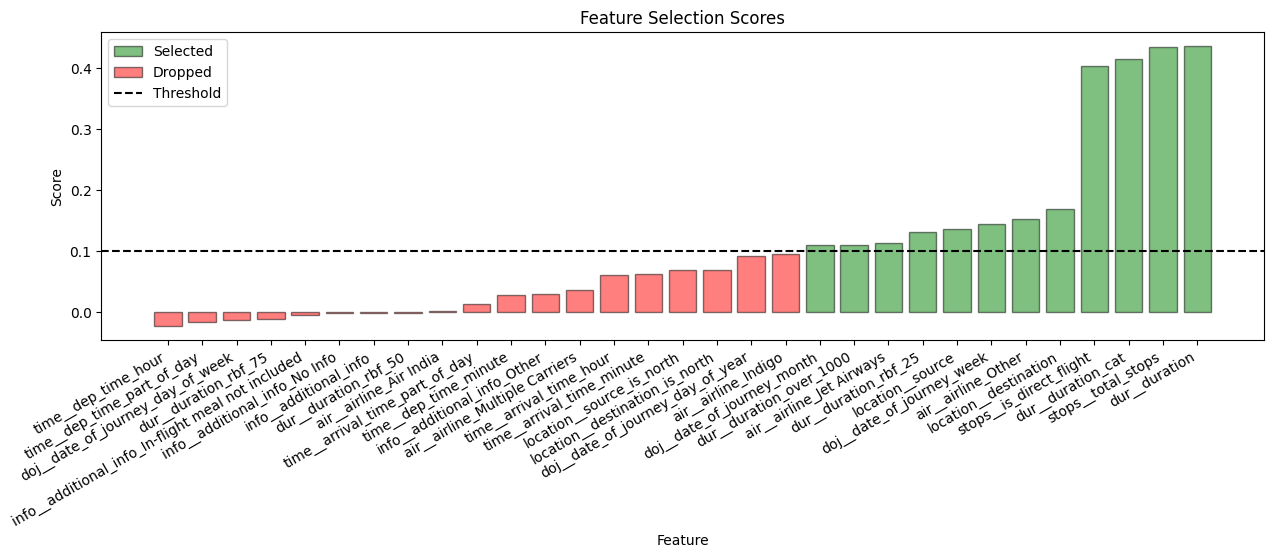

In [103]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 12 features out of that

In [104]:
# We use wrapper method for feature selection